In [9]:
import os
import glob
import scipy as sp
from scipy import signal
import pandas as pd
import numpy as np
import tensorflow as tf
tf.random.set_seed(1)
import tensorflow.keras as keras
from keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, GaussianNoise
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
import dffuncs as dff
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import os

import models
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [13]:
# Keeping the index labels (wavelength) for later use (for plotting etc.)
df.columns= df.columns.astype(float)
column_labels = df.columns.tolist
column_labels

<bound method IndexOpsMixin.tolist of Float64Index([   1.0,    2.0,    3.0,    4.0,    5.0,    6.0,    7.0,    8.0,
                 9.0,   10.0,
              ...
              1303.0, 1304.0, 1305.0, 1306.0, 1307.0, 1308.0, 1309.0, 1310.0,
              1311.0, 1312.0],
             dtype='float64', length=1312)>

In [17]:
# Converting the data to numpy array
data_raw = df.to_numpy()
print(f'Raw data shape: {data_raw.shape}')  # Sanity check of shapes

Raw data shape: (209, 1312)


In [18]:
data_processed = data_raw

# Slicing the data

train_data = data_processed[:int(data_processed.shape[0]*0.8), :]                # training set split
print(train_data)
test_data = data_processed[int(data_processed.shape[0]*0.8):, :]                 # test set split
print("Train dataset shape: {}".format(train_data.shape))
print("Test dataset shape: {}".format(test_data.shape))

[[0.0236  0.0208  0.0258  ... 0.0253  0.00914 0.     ]
 [0.0354  0.0542  0.0618  ... 0.0487  0.0354  0.     ]
 [0.0475  0.0468  0.0493  ... 0.0215  0.0406  0.     ]
 ...
 [0.0144  0.0082  0.0101  ... 0.00833 0.00598 3.     ]
 [0.0175  0.0117  0.00565 ... 0.0109  0.0102  3.     ]
 [0.0103  0.00933 0.0125  ... 0.00603 0.00469 3.     ]]
Train dataset shape: (167, 1312)
Test dataset shape: (42, 1312)


In [50]:
BATCH_SIZE = 4                        # (opt) Tested for our dataset to be the most suitable
data_size = train_data.shape[0]           # Number of data_points
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(data_size).batch(BATCH_SIZE)         # Shuffle and build the train dataset
train_data[1]

array([0.00489, 0.0224 , 0.0347 , ..., 0.0103 , 0.0175 , 0.0315 ])

In [51]:
feature_dim = train_data.shape[1]

noise_dim = feature_dim            # Dimension of the input noise vector to the generator (opt)

# Dimension of each feature (row)
feature_dim

1311

In [ ]:
layers.Dense(feature_dim)

In [ ]:
generator = make_generator_model()
generator.summary()

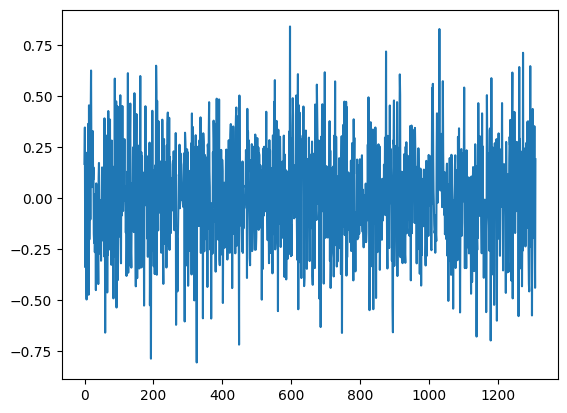

In [56]:
noise = tf.random.normal([1, noise_dim])
generated_data = generator(noise, training=False)
generated_data_ = generated_data.numpy().reshape(-1).tolist()
plt.plot(generated_data_)

In [57]:
def make_discriminator_model():

    # Implementing a ConvNet discriminator
    model = tf.keras.Sequential()

    model.add(layers.Input(shape= (feature_dim)))
    model.add(layers.Reshape([feature_dim, 1]))

    model.add(layers.Conv1D(kernel_size= 16, filters= 256, activation='leaky_relu'))  #(opt) (number of filters and kernel size)
    model.add(layers.MaxPool1D())
    model.add(layers.Dropout(0.02))

    model.add(layers.Conv1D(kernel_size= 16, filters= 128))    #(opt) (number of filters and kernel size)
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(layers.MaxPool1D())
    model.add(layers.Dropout(0.02))                                             #(opt) (dropout probability)

    model.add(layers.Flatten())
    model.add(layers.Dense(64))                                                         #(opt) (number of nodes in layer)
    model.add(layers.Dense(1))
    model.compile()

    return model

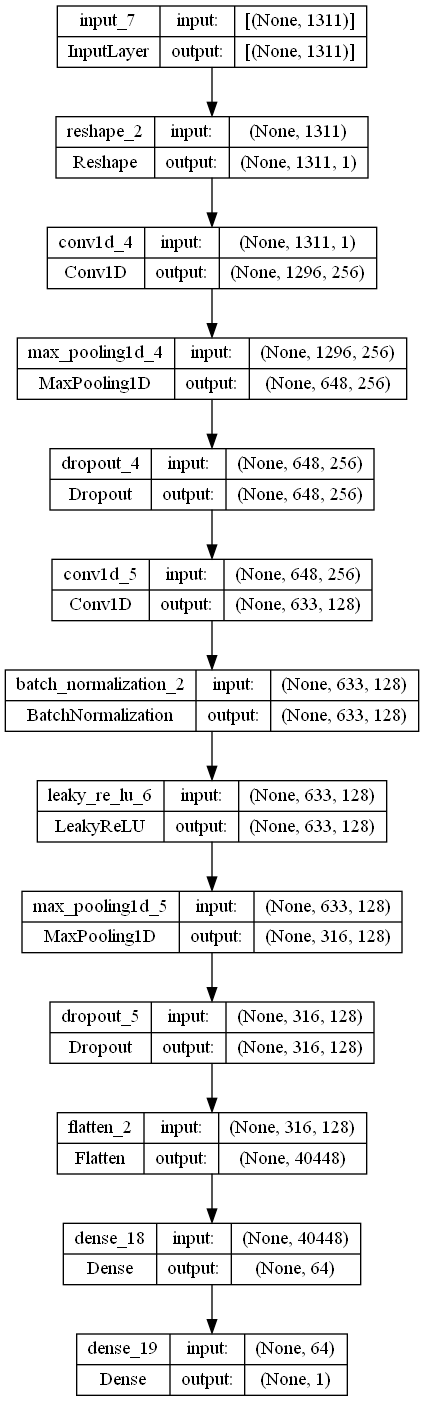

In [58]:
plot_model(make_discriminator_model(),to_file="discriminator.png",show_shapes=True)

In [59]:
discriminator = make_discriminator_model()
decision = discriminator(generated_data)            # Get real or fake for the input we just got out of the generator
decision
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 1311, 1)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 1296, 256)         4352      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 648, 256)         0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 648, 256)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 633, 128)          524416    
                                                                 
 batch_normalization_3 (Batc  (None, 633, 128)         512       
 hNormalization)                                      

In [60]:
# Computation of cross entropy loss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Definining the discriminator loss

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

# Defining the generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [61]:
# Defining training optimizers

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-5)

In [62]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [63]:
seed = tf.random.normal([1, noise_dim])   # Fixed input noise distribution to monitor training effect on that distribution

def draw_training_evolution(model, epoch, noise_input= seed):
  """
    Function that takes in the generator model, epoch number, and
    does a prediction and plots the generated singal then saves it.
  """
  # `training` is set to False.
  # Thus, all layers run in inference mode (batchnorm).
  predictions = model(noise_input, training=False)

  for i in range(predictions.shape[0]):
    fig = plt.figure()
    plt.plot(predictions[i].numpy().tolist())
    plt.savefig('output/evolution/image_at_epoch_{:04d}_{:04d}.png'.format(epoch, i))
    plt.close()

def generate_data(model, num_synthetic_to_gen=1):
  """
    Function that takes in the generator model and
    does a prediction and returns it as a numpy array.
  """
  noise_input = tf.random.normal([num_synthetic_to_gen, noise_dim])
  predictions = model(noise_input, training=False)
  predictions = predictions.numpy()
  return predictions

def calc_accuracy(prediction):
  """
    Function that takes in the some data judgements
    from the discriminator and get the average of
    judgements that indicate how the discriminator is fooled.
  """
  prediction_clipped = tf.clip_by_value(prediction, 0.0, 1.0, name=None)
  return tf.reduce_mean(prediction_clipped)

In [64]:
# `tf.function` # This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    """
      Function for implementing one training step
      of the GAN model
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim], seed=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_data = generator(noise, training=True)

      real_output = discriminator(data, training=True)
      fake_output = discriminator(generated_data, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      acc = calc_accuracy(fake_output)



    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, acc

In [65]:
numofEPOCHS = 20000 #(opt)
def train(dataset, epochs):
  """
    Main GAN Training Function
  """
  epochs_gen_losses, epochs_disc_losses, epochs_accuracies = [], [], []

  for epoch in range(epochs):
    start = time.time()

    gen_losses, disc_losses, accuracies = [], [], []

    for data_batch in dataset:
      gen_loss, disc_loss, acc = train_step(data_batch)
      accuracies.append(acc)
      gen_losses.append(gen_loss)
      disc_losses.append(disc_loss)

    epoch_gen_loss  = np.average(gen_losses)
    epoch_disc_loss = np.average(disc_losses)
    epoch_accuracy = np.average(accuracies)
    epochs_gen_losses.append(epoch_gen_loss)
    epochs_disc_losses.append(epoch_disc_loss)
    epochs_accuracies.append(epoch_accuracy)
    print("Epoch: {}/{}".format(epoch+1, epochs))
    print("Generator Loss: {}, Discriminator Loss: {}".format(epoch_gen_loss, epoch_disc_loss))
    print("Accuracy: {}".format(epoch_accuracy))

    # Draw the model every 50 epochs
    if (epoch + 1) % 2 == 0:
      draw_training_evolution(generator, epoch+1)

    # Save the model every 2 epochs for the last 2000 epochs
    if (epoch + 1) % 2 == 0 and epoch > (numofEPOCHS - 2000):
      checkpoint.save(file_prefix = checkpoint_prefix)   # Comment not to save model checkpoints while training


  return epochs_gen_losses, epochs_disc_losses, epochs_accuracies

In [66]:
EPOCHS = numofEPOCHS

epochs_gen_losses, epochs_disc_losses, epochs_accuracies = train(train_dataset, EPOCHS)

Epoch: 1/20000
Generator Loss: 4.4301676750183105, Discriminator Loss: 0.2630390524864197
Accuracy: 0.010428916662931442
Epoch: 2/20000
Generator Loss: 6.243422985076904, Discriminator Loss: 0.02194219082593918
Accuracy: 0.0
Epoch: 3/20000
Generator Loss: 7.702542304992676, Discriminator Loss: 0.005610225256532431
Accuracy: 0.0
Epoch: 4/20000
Generator Loss: 9.06602954864502, Discriminator Loss: 0.0015200154157355428
Accuracy: 0.0
Epoch: 5/20000
Generator Loss: 10.426769256591797, Discriminator Loss: 0.0004906781832687557
Accuracy: 0.0
Epoch: 6/20000
Generator Loss: 11.782449722290039, Discriminator Loss: 0.00014205800835043192
Accuracy: 0.0
Epoch: 7/20000
Generator Loss: 12.442048072814941, Discriminator Loss: 4.804656055057421e-05
Accuracy: 0.0
Epoch: 8/20000
Generator Loss: 14.306732177734375, Discriminator Loss: 1.4514273061649874e-05
Accuracy: 0.0
Epoch: 9/20000
Generator Loss: 15.374754905700684, Discriminator Loss: 4.944208285451168e-06
Accuracy: 0.0
Epoch: 10/20000
Generator Lo

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

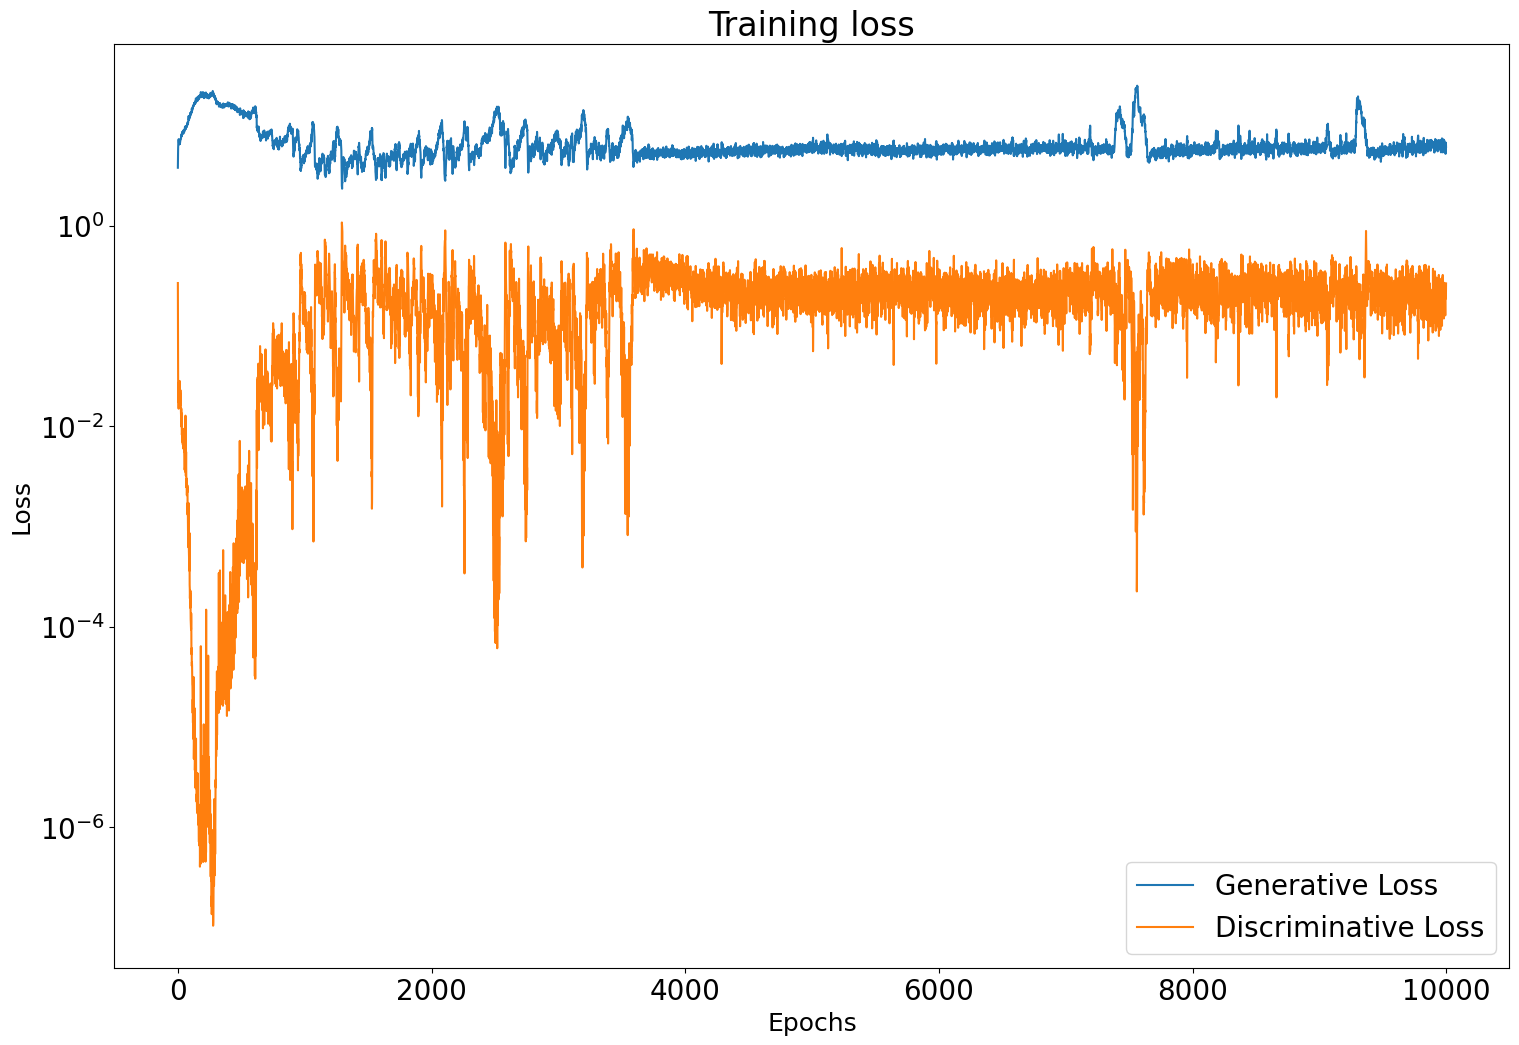

In [24]:
plt.figure()
plt.rcParams.update({'font.size': 20}) # must be set on top
ax = pd.DataFrame(
    {
        'Generative Loss': epochs_gen_losses,
        'Discriminative Loss': epochs_disc_losses,
    }
).plot(title='Training loss', logy=True, figsize=(18,12))
ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Loss", fontsize=18)

# Save figure using 600 dpi
plt.savefig("training.png", dpi=300)
plt.show()

In [25]:
# Save the model
generator.save('D:\HUDAN_FYP\\tBLG\\2DMaterials\models\generator_model23o.ckpt', overwrite=True)

INFO:tensorflow:Assets written to: D:\HUDAN_FYP\tBLG\2DMaterials\models\generator_model23o.ckpt\assets


In [26]:
def get_rmse(synthetic_datapoint, original_datapoint):
    """
        Function that calculates the RMS between two datapoints
    """
    return np.sqrt(np.average((synthetic_datapoint - original_datapoint)**2))


def get_rmse_on_batch(synthetic_data, test_dataset):
    """
        Function that calculates the minimum RMS between
        a batch of synthetic datapoints and a batch of test samples
    """

    rmse_all = []

    for gen in synthetic_data:
        rmse = np.inf
        for test_datapoint in test_dataset:
            current_rmse = get_rmse(gen, test_datapoint)
            if current_rmse < rmse:
                rmse = current_rmse
        rmse_all.append(rmse)

    return np.average(rmse_all)

In [27]:
def get_prmsd(synthetic_datapoint, original_datapoint):
    """
        Function that calculates the percent root mean square
        difference between two datapoints
    """
    return np.sqrt(100 * (np.sum((synthetic_datapoint - original_datapoint)**2)) / (np.sum(synthetic_datapoint**2)))

def get_prmsd_on_batch(synthetic_data, test_dataset):
    """
        Function that calculates the minimum percent root mean square
        difference between a batch of synthetic
        datapoints and a batch of test samples
    """

    prmsd_all = []

    for gen in synthetic_data:
        prmsd = np.inf
        for test_datapoint in test_dataset:
            current_prmsd = get_prmsd(gen, test_datapoint)
            if current_prmsd < prmsd:
                prmsd = current_prmsd
        prmsd_all.append(prmsd)

    return np.average(prmsd_all)

In [28]:
def get_mae(synthetic_datapoint, original_datapoint):
    """
        Function that calculates the mean absolute
        error between two datapoints
    """
    return np.average(np.abs(synthetic_datapoint - original_datapoint))

def get_mae_on_batch(synthetic_data, test_dataset):
    """
        Function that calculates the minimum mean absolute
        error between a batch of synthetic datapoints and a batch of test samples
    """

    mae_all = []

    for gen in synthetic_data:
        mae = np.inf
        for test_datapoint in test_dataset:
            current_mae = get_mae(gen, test_datapoint)
            if current_mae < mae:
                mae = current_mae
        mae_all.append(mae)

    return np.average(mae_all)

In [29]:
batch = generate_data(generator, num_synthetic_to_gen= 10)
rmse_ = get_rmse_on_batch(batch, test_data)
prmsd_ = get_prmsd_on_batch(batch, test_data)
mae_ = get_mae_on_batch(batch, test_data)
print("RMSe at Testing Dataset: {}".format(rmse_))
print("PRMSD at Testing Dataset: {}".format(prmsd_))
print("MAE at Testing Dataset: {}".format(mae_))

RMSe at Testing Dataset: 0.04785361459408264
PRMSD at Testing Dataset: 3.114560170737991
MAE at Testing Dataset: 0.026442460155564194


In [30]:
def save_data_to_csv(data, filepath):
    """
        Function that takes in the data as numpy array,
        converts to pandas dataframe and then saves the .csv file.
    """
   # columns = ["Column{}".format(i) for i in range(data.shape[1])]


    df = pd.DataFrame(data, columns= column_labels())
    df.to_csv(filepath,sep=';')

def draw_generated_figures(data, folderpath):
    """
        Function that takes in the generated batch of data
        and saves the corresponding signal outputs as figures
    """
    for i in range(data.shape[0]):
        fig = plt.figure()
        plt.plot(data[i].tolist(), 'r')
        plt.savefig(folderpath + '/generated_sample_{:04d}.png'.format(i))
        plt.close()


In [31]:
# Generating samples
generated_batch = generate_data(generator, num_synthetic_to_gen=1000)
os.chdir('D:\HUDAN_FYP\\tBLG\\2DMaterials')
# Undoing any normalization that happened
# generated_batch = ((generated_batch * std_dev) + means).astype(np.int32)     # Converting to ints
save_data_to_csv(generated_batch, 'output/csv/samples1000.csv')
# draw_generated_figures(generated_batch, 'output/generated_samples')
print("Saved successfully!")

Saved successfully!


In [45]:
loaded_generator = tf.keras.models.load_model('models/generator_model23o.ckpt')        # Load the model
loaded_generator.compile()                                                          # Compile the model
generated_data = generate_data(generator, num_synthetic_to_gen=1)
print(generated_data)

[[ 0.12435213  0.11806642  0.10417248  0.10095266  0.10734725  0.12175308
   0.13391039  0.14287965  0.15312366  0.15731062  0.15906554  0.1567316
   0.14845026  0.13967127  0.13482693  0.13415414  0.1355836   0.1397633
   0.1349334   0.1304547   0.125004    0.11689502  0.10891932  0.10821112
   0.10541217  0.10624433  0.11177811  0.1224973   0.13816378  0.16973372
   0.21568134  0.25896353  0.22965004  0.22712809  0.18972915  0.15418781
   0.13748038  0.11980177  0.10619803  0.0994776   0.09515671  0.08971065
   0.08299531  0.07839496  0.07403196  0.06964774  0.06493367  0.06194178
   0.05642896  0.052607    0.04964935  0.04759769  0.04226927  0.0408523
   0.03829639  0.03710428  0.03547069  0.03771744  0.03708318  0.03855803
   0.03677146  0.03697044  0.03611323  0.03588601  0.03678863  0.03354371
   0.03437179  0.03275022  0.03300768  0.03433073  0.03309278  0.02901195
   0.02590251  0.02464825  0.02586273  0.02569972  0.02610403  0.02594415
   0.02658782  0.02700769  0.0255702   0.

In [24]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest
checkpoint.restore(latest)
generator(noise)

<tf.Tensor: shape=(1, 1312), dtype=float32, numpy=
array([[ 0.01055198,  0.01290728,  0.02168099, ...,  0.00601027,
         0.00671637, -0.2176301 ]], dtype=float32)>

In [25]:
# Save the checkpoints as spectra
for x in range(1000):
    checkpoint.restore('./training_checkpoints/ckpt-' + str(x+1))
    checkpoint.generator(noise)
    generated_batch = generate_data(generator, num_synthetic_to_gen=1)
    save_data_to_csv(generated_batch, 'output/cp/synth_o_raw_bz4_bn_GN00_model23_cp' + str(x+1) + '.csv')
print("Saved successfully!")

KeyboardInterrupt: 

In [48]:
cwd = os.getcwd()
print(cwd) # Sanity check: being in the correct directory

D:\HUDAN_FYP\tBLG\2DMaterials


In [27]:
gs=pd.read_csv('output/csv/samples1000.csv',delimiter=';',index_col=0)
gs

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1302.0,1303.0,1304.0,1305.0,1306.0,1307.0,1308.0,1309.0,1310.0,1311.0
0,0.072704,0.068933,0.077620,0.080547,0.079573,0.060479,0.063869,0.063400,0.066895,0.072351,...,0.076582,0.079263,0.053207,0.065982,0.062474,0.044028,0.044876,0.058598,0.065563,-0.426555
1,0.029867,0.035910,0.037106,0.030164,0.043146,0.029566,0.023579,0.023707,0.018914,0.030763,...,0.027786,0.031029,0.020037,0.016330,0.021304,0.011688,0.012821,0.017099,0.019425,-0.088495
2,0.059814,0.056206,0.063507,0.066535,0.067021,0.049143,0.050754,0.047951,0.057479,0.060938,...,0.054404,0.055784,0.035128,0.041144,0.038395,0.020265,0.027929,0.040322,0.043294,-0.286527
3,0.056439,0.054637,0.058535,0.063028,0.063601,0.046841,0.046360,0.042320,0.051228,0.057827,...,0.053788,0.052974,0.030469,0.037390,0.034173,0.019462,0.027724,0.039601,0.043645,-0.308383
4,0.060743,0.056504,0.063429,0.067498,0.067269,0.049021,0.047092,0.049875,0.057806,0.059487,...,0.060003,0.061595,0.042131,0.048042,0.045181,0.028635,0.033756,0.046453,0.049616,-0.299800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.063477,0.060413,0.067425,0.067533,0.070603,0.049483,0.051353,0.051905,0.058672,0.063542,...,0.057027,0.055372,0.036247,0.041244,0.038888,0.022186,0.029788,0.044001,0.047408,-0.332351
996,0.050619,0.047788,0.054201,0.056515,0.057097,0.041449,0.041821,0.039911,0.048213,0.051620,...,0.048585,0.048432,0.029620,0.036453,0.034138,0.020432,0.026025,0.039688,0.043386,-0.198252
997,0.049116,0.042880,0.046472,0.049101,0.049961,0.032460,0.028760,0.031184,0.045389,0.036619,...,0.039161,0.048017,0.024240,0.024240,0.023914,0.020277,0.021914,0.036022,0.035159,-0.089001
998,0.053360,0.049056,0.054449,0.057254,0.057540,0.040372,0.041466,0.041886,0.049899,0.051701,...,0.049818,0.049954,0.032465,0.039670,0.037159,0.020983,0.026372,0.039998,0.043063,-0.215548
